In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# merge original dataset
train_df = pd.read_csv("../data/raw/train.csv")
X_test = pd.read_csv("../data/raw/test.csv")
original_df = pd.read_csv("../data/raw/original.csv")
train_df = pd.concat([train_df, original_df], axis=0)

In [3]:
categorical_columns = train_df.select_dtypes(include=['object']).columns.to_list()

# Remove 'loan_status' from the list
if 'loan_status' in categorical_columns:  
    categorical_columns.remove('loan_status')

print(categorical_columns) 

['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [4]:
numerical_columns = train_df.select_dtypes(include=['int', 'float']).columns.to_list()

for column in ['id', 'loan_status']:
    if column in numerical_columns:
        numerical_columns.remove(column)
    
print(numerical_columns)

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


## 1 Data Preprocessing

### 1.1 Drop unique identifier (`id` column)

In [5]:
train_df = train_df.drop(columns=['id'])
X_test = X_test.drop(columns=['id'])

### 1.2 Drop rows with missing values

In [6]:
# Drop rows with missing values in 'person_emp_length' and 'loan_int_rate'
train_df = train_df.dropna(subset=['person_emp_length', 'loan_int_rate'])

In [7]:
print(f'Shape of train set after dropping missing values: {train_df.shape}')

Shape of train set after dropping missing values: (87283, 12)


In [8]:
train_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

### 1.3 Drop rows with outliers

In [9]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

    return multiple_outliers


# params dataset, number of outliers for rejection, list of features
outliers_to_drop = detect_outliers(train_df, 2, numerical_columns)

In [10]:
len(outliers_to_drop)

766

In [11]:
train_df = train_df.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [12]:
print(f'Shape of train set after dropping outliers: {train_df.shape}')

Shape of train set after dropping outliers: (85902, 12)


In [13]:
# Visual inspection after dropping the outliers




### 1.4 Split features with target

In [14]:
X_train = train_df.drop(columns=['loan_status'])
y_train = train_df['loan_status']

In [15]:
if X_train.shape[0] == y_train.shape[0]:
    print(True)

True


### 1.5 Encoding categorical features

In [16]:
def one_hot_encode(df, features):
    """
    This function takes a DataFrame, identifies non-numeric (categorical) columns,
    applies one-hot encoding to them, and returns the modified DataFrame.
    """
    for col in features:
        df_dum = pd.get_dummies(df[col], prefix=col, dtype=int)
        df = df.drop(col, axis=1)
        df = pd.concat([df, df_dum], axis=1)
    return df


X_train = one_hot_encode(X_train, categorical_columns)
X_test = one_hot_encode(X_test, categorical_columns)

## 2 Feature Engineering

### 2.1 Generate new features

In [17]:
def feature_generation(df_):
    df = df_.copy()
    # I create this feature because interest are the actual money to be paid in each year
    df['interest_percent_income'] = round(df['loan_int_rate'] * df['loan_amnt'] / df['person_income'], 2)
    return df

X_train = feature_generation(X_train)
X_test = feature_generation(X_test)

In [18]:
X_train.shape

(85902, 27)

### 2.2 Balance the dataset

Common ways to handle imbalanced dataset:
1. Random under-sampling
2. Random over-sampling
3. Synthetic over-sampling: SMOTE

The method I choose here is SMOTE. I don't go with under-sampling because we don't have very large training set so I don't want to miss more information. Oversampling won't have this problem but it may suffer from overfitting.

In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [20]:
X = X_res.copy()
y = y_res.copy()

In [21]:
y.value_counts()

loan_status
0    71656
1    71656
Name: count, dtype: int64

In [22]:
X.shape

(143312, 27)

## 3 Model building

In [59]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [60]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  
)

strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [61]:
def train_and_evaluate_model(X, y, model_name, train=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    if train:
        if model_name == 'Logistic Regression':
            model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])
        elif model_name == 'Random Forest':
            model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
        elif model_name == 'Xgboost':
            model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier())])
        elif model_name == 'Catboost':
            model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', CatBoostClassifier(verbose=0))])
        else:
            raise ValueError(f'Model {model_name} not supported.')
        
        # Calculate the mean straitified cross validation roc_auc score
        scores = np.mean(cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=strat_kf))
        print(f'The mean cross validation score for {model_name} is {scores:.2f}')
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]  
        
        # Calculate and print AUC-ROC score for the test set
        test_auc_roc = roc_auc_score(y_test, y_pred_proba)
        print(f'The AUC-ROC score for the test set of {model_name} is {test_auc_roc:.2f}')
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        feature_importance = None
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            feature_importance = model.named_steps['classifier'].feature_importances_
            # Plot feature importance
            features = X.columns
            sorted_idx = feature_importance.argsort()[::-1]  # Get the indices of sorted features
            
            # Plot sorted feature importance
            sns.barplot(x=feature_importance[sorted_idx], y=features[sorted_idx])
            plt.title(f'Feature Importance for {model_name}')
            plt.show()
    
    return model, scores, feature_importance

The mean cross validation score for Random Forest is 0.99
The AUC-ROC score for the test set of Random Forest is 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     21498
           1       0.99      0.94      0.97     21496

    accuracy                           0.97     42994
   macro avg       0.97      0.97      0.97     42994
weighted avg       0.97      0.97      0.97     42994



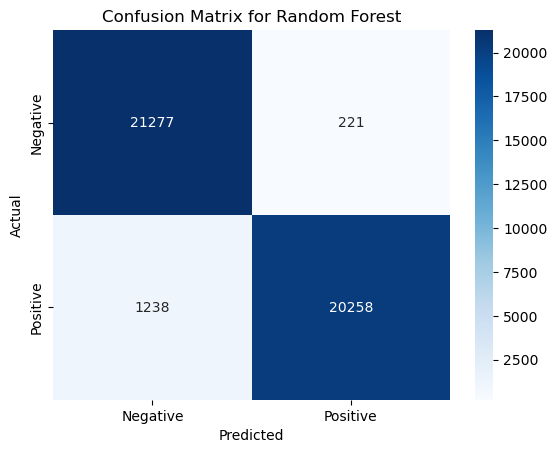

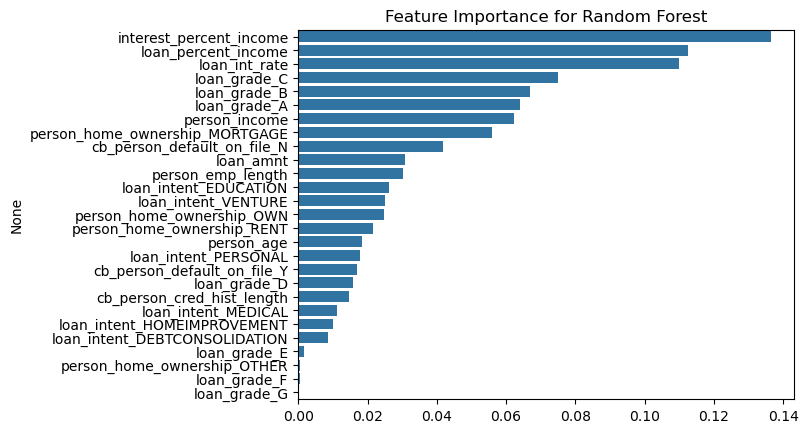

In [62]:
model_rf, auc_roc_rf, importance_rf = train_and_evaluate_model(X, y, 'Random Forest', train=True)

/Users/lirt/miniconda3/envs/mds574/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lirt/miniconda3/envs/mds574/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

The mean cross validation score for Logistic Regression is 0.97
The AUC-ROC score for the test set of Logistic Regression is 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     21498
           1       0.96      0.90      0.93     21496

    accuracy                           0.93     42994
   macro avg       0.93      0.93      0.93     42994
weighted avg       0.93      0.93      0.93     42994



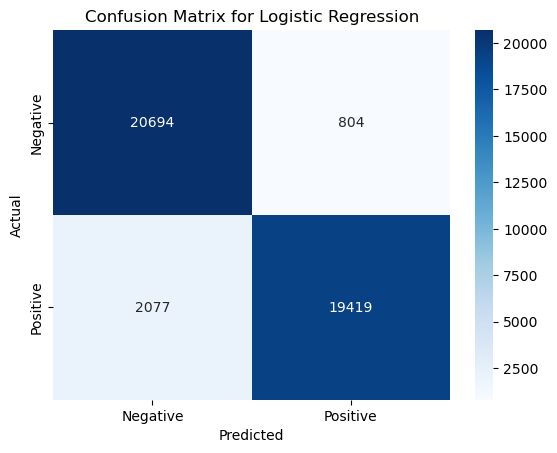

In [63]:
model_lr, auc_roc_lr, importance_lr = train_and_evaluate_model(X, y, 'Logistic Regression', train=True)

The mean cross validation score for Xgboost is 0.99
The AUC-ROC score for the test set of Xgboost is 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     21498
           1       0.99      0.95      0.97     21496

    accuracy                           0.97     42994
   macro avg       0.97      0.97      0.97     42994
weighted avg       0.97      0.97      0.97     42994



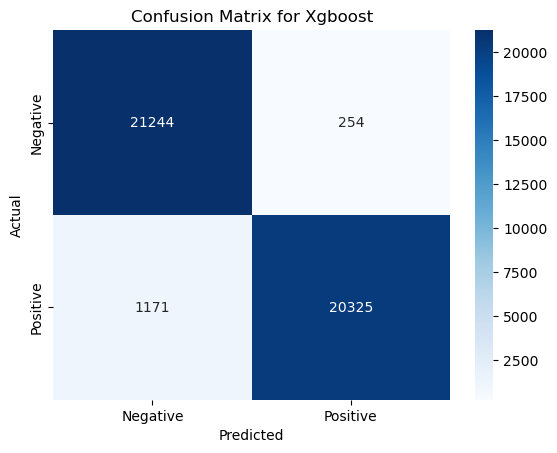

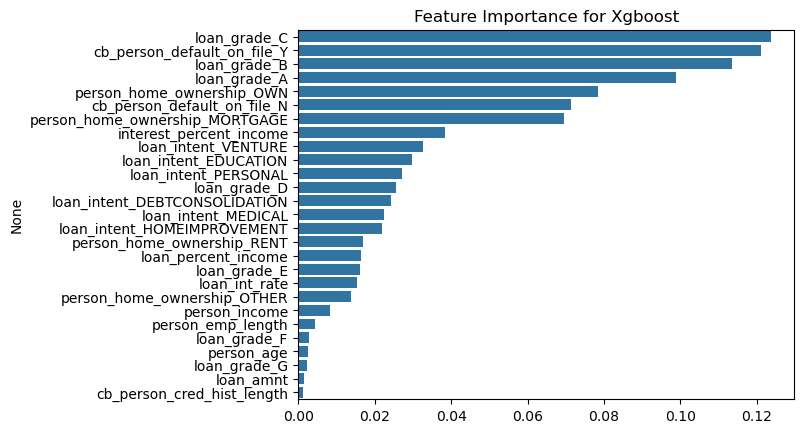

In [64]:
model_xgb, auc_roc_xgb, importance_xgb = train_and_evaluate_model(X, y, 'Xgboost', train=True)

In [ ]:
model_cb, auc_roc_cb, importance_cb = train_and_evaluate_model(X, y, 'Catboost', train=True)

## 4 Hyper Tuning